# Importing libraries


In [244]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from wordcloud import WordCloud
import squarify 
import re
%matplotlib inline 

# Data Formatting

csv file contains the information of all startups (India) from 2015 to 2020

In [191]:
sheet_id = '1gzlRgRWWjUqNfjL9R19NMnJHwO0azm6aM6HA9EeaIkk'
df = pd.read_csv(f'https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv')

#### Sample of our dataset

In [192]:
df.head()

,Sr No,Date dd/mm/yyyy,Startup Name,Industry Vertical,SubVertical,City Location,Investors Name,InvestmentnType,Amount in USD,Remarks
0,1,09/01/2020,BYJU’S,E-Tech,E-learning,Bengaluru,Tiger Global Management,Private Equity Round,"20,00,00,000",NaN
1,2,13/01/2020,Shuttl,Transportation,App based shuttle service,Gurgaon,Susquehanna Growth Equity,Series C,"80,48,394",NaN
2,3,09/01/2020,Mamaearth,E-commerce,Retailer of baby and toddler products,Bengaluru,Sequoia Capital India,Series B,"1,83,58,860",NaN
3,4,02/01/2020,https://www.wealthbucket.in/,FinTech,Online Investment,New Delhi,Vinod Khatumal,Pre-series A,"30,00,000",NaN
4,5,02/01/2020,Fashor,Fashion and Apparel,Embroiled Clothes For Women,Mumbai,Sprout Venture Partners,Seed Round,"18,00,000",NaN


In [193]:
df.tail()

,Sr No,Date dd/mm/yyyy,Startup Name,Industry Vertical,SubVertical,City Location,Investors Name,InvestmentnType,Amount in USD,Remarks
3039,3040,29/01/2015,Printvenue,NaN,NaN,NaN,Asia Pacific Internet Group,Private Equity,"45,00,000",NaN
3040,3041,29/01/2015,Graphene,NaN,NaN,NaN,KARSEMVEN Fund,Private Equity,"8,25,000",Govt backed VC Fund
3041,3042,30/01/2015,Mad Street Den,NaN,NaN,NaN,"Exfinity Fund, GrowX Ventures.",Private Equity,"15,00,000",NaN
3042,3043,30/01/2015,Simplotel,NaN,NaN,NaN,MakeMyTrip,Private Equity,NaN,"Strategic Funding, Minority stake"
3043,3044,31/01/2015,couponmachine.in,NaN,NaN,NaN,UK based Group of Angel Investors,Seed Funding,"1,40,000",NaN


### Dimentions of dataframe

In [195]:
print('Rows = {rows} and Columns = {columns} '.format(rows=df.shape[0],columns=df.shape[1]))

Rows = 3044 and Columns = 10 


# Cleaning and Preparing Data

> Setting the columns name

In [196]:
df.columns = ['SNo','date','startup_name','industry_vertical','sub_vertical','city_location','investor_name','investment_type','amount_usd','remarks']

In [197]:
print('Columns and their dftypes')
df.dtypes

Columns and their dftypes


SNo                   int64
date                 object
startup_name         object
industry_vertical    object
sub_vertical         object
city_location        object
investor_name        object
investment_type      object
amount_usd           object
remarks              object
dtype: object

* Dataframe contains lots of Nan values in remarks columns, we can neglect this column

In [198]:
total = df.isnull().sum().sort_values(ascending=False)
percent = ((df.isnull().sum()/ df.isnull().count())*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent],axis=1,keys=['Total', 'Percent %'])
missing_data.head()

,Total,Percent %
remarks,2625,86.235217
amount_usd,960,31.537451
sub_vertical,936,30.749014
city_location,180,5.913272
industry_vertical,171,5.617608


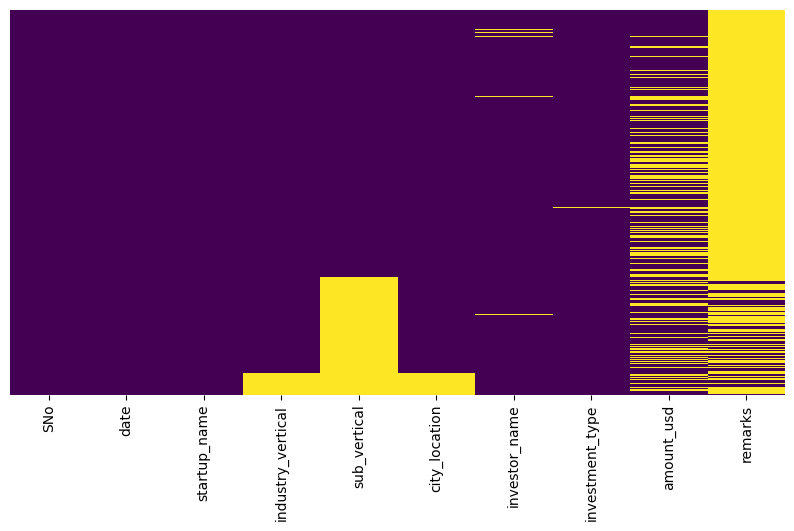

In [200]:
plt.figure(figsize=(10,5))
sns.heatmap(df.isnull(),cmap='viridis',yticklabels=False,cbar=False)
plt.show()

* Here yellow means missing data i.e. Nan values
* x axis represents columns of dataset

In [201]:
df.drop('remarks',axis=1,inplace=True)
df.drop('SNo',axis=1,inplace=True)

In [202]:
df.columns

Index(['date', 'startup_name', 'industry_vertical', 'sub_vertical',
       'city_location', 'investor_name', 'investment_type', 'amount_usd'],
      dtype='object')

#### Removing the inconsistency

> cleaning the columns

In [203]:
def clean_string(x):
    return str(x).replace("\\xc2\\xa0","").replace("\\\\xc2\\\\xa0","").replace("\\xe2\\x80\\x99s","").replace(",\\xc2\\xa0","")

for col in ['startup_name', 'industry_vertical','sub_vertical','city_location', 'investor_name', 'investment_type', 'amount_usd']:
    df[col] = df[col].apply(lambda x: clean_string(x))


In [204]:
df['date'] = df['date'].replace({
    '01/07/015': '01/07/2015',
    '\\\\xc2\\\\xa010/7/2015': '10/07/2015',
    '12/05.2015': '12/05/2015',
    '13/04.2015': '13/04/2015',
    '15/01.2015': '15/01/2015',
    '22/01//2015': '22/01/2015',
    '05/072018': '05/07/2018'
})



> Converting the column `date` into datetime type

In [205]:
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

* No Duplicate value present

In [206]:
df.duplicated().sum()

0

* Cleaning column `startup_name`

In [207]:
df.loc[df['startup_name'].isin(['https://www.wealthbucket.in/']), 'startup_name'] = 'wealthbucket'

* Cleaning column `city_loaction`

In [208]:
df.loc[df['city_location'].isin(['\\\\xc2\\\\xa0Noida', '\\xc2\\xa0Noida']), 'city_location'] = 'Noida'
df.loc[df['city_location'].isin(['\\\\xc2\\\\xa0Bangalore', '\\xc2\\xa0Bangalore', 'Bangalore']), 'city_location'] = 'Bengaluru'
df.loc[df['city_location'].isin(['\\\\xc2\\\\xa0New Delhi', '\\xc2\\xa0New Delhi', 'delhi', 'Delhi', 'New Delhi']), 'city_location'] = 'Delhi'
df.loc[df['city_location'].isin(['\\\\xc2\\\\xa0Gurgaon', 'Gurugram']), 'city_location'] = 'Gurgaon'
df.loc[df['city_location'].isin(['\\\\xc2\\\\xa0Mumbai', '\\xc2\\xa0Mumbai']), 'city_location'] = 'Mumbai'

* Cleaning column `industry_vertical`

In [209]:
df.loc[df['industry_vertical'] == "\\\\xc2\\\\xa0News Aggregator mobile app", 'industry_vertical'] = 'News Aggregator mobile app'
df.loc[df['industry_vertical'] == "\\\\xc2\\\\xa0Online Jewellery Store", 'industry_vertical'] = 'Online Jewellery Store'
df.loc[df['industry_vertical'] == "\\\\xc2\\\\xa0Fashion Info Aggregator App", 'industry_vertical'] = 'Fashion Info Aggregator App'
df.loc[df['industry_vertical'] == "\\\\xc2\\\\xa0Online Study Notes Marketplace", 'industry_vertical'] = 'Online Study Notes Marketplace'
df.loc[df['industry_vertical'] == "\\\\xc2\\\\xa0Warranty Programs Service Administration", 'industry_vertical'] = 'Warranty Programs Service Administration'
df.loc[df['industry_vertical'] == "\\\\xc2\\\\xa0Pre-School Chain", 'industry_vertical'] = 'Pre-School Chain'
df.loc[df['industry_vertical'] == "\\\\xc2\\\\xa0Premium Loyalty Rewards Point Management", 'industry_vertical'] = 'Premium Loyalty Rewards Point Management'
df.loc[df['industry_vertical'] == "\\\\xc2\\\\xa0Contact Center Software Platform", 'industry_vertical'] = 'Contact Center Software Platform'
df.loc[df['industry_vertical'] == "\\\\xc2\\\\xa0Casual Dining restaurant Chain", 'industry_vertical'] = 'Casual Dining restaurant Chain'
df.loc[df['industry_vertical'] == "\\\\xc2\\\\xa0Online Grocery Delivery", 'industry_vertical'] = 'Online Grocery Delivery'
df.loc[df['industry_vertical'] == "Online home d\\\\xc3\\\\xa9cor marketplace", 'industry_vertical'] = 'Online home decor marketplace'
df.loc[df['industry_vertical'].isin(["ECommerce", "E-Commerce", "E-commerce", "Ecommerce"]), 'industry_vertical'] = 'eCommerce'
df.loc[df['industry_vertical'].isin(["Fin-Tech"]), 'industry_vertical'] = 'FinTech'

* Cleaning column `investor_name`

In [210]:
df.loc[df['investor_name'].isin(['Undisclosed investors', 'Undisclosed', 'undisclosed investors', 'Undisclosed Investor', 'Undisclosed investors',' ']), 'investor_name'] = 'Undisclosed Investors'
df.loc[df['investor_name'] == "\\\\xc2\\\\xa0Tiger Global", 'investor_name'] = 'Tiger Global'
df.loc[df['investor_name'] == "\\\\xc2\\\\xa0IndianIdeas.com", 'investor_name'] = 'IndianIdeas'
df.loc[df['investor_name'] == "\\\\xc2\\\\xa0IvyCap Ventures, Accel Partners, Dragoneer Investment Group", 'investor_name'] = 'IvyCap Ventures, Accel Partners, Dragoneer Investment Group'
df.loc[df['investor_name'] == "\\\\xc2\\\\xa0Goldman Sachs", 'investor_name'] = 'Goldman Sachs'
df.loc[df['investor_name']== 'What\\xe2\\x80\\x99s Up Life','investor_name'] = 'What Up Life'
df.loc[df['investor_name']== '\\xc2\\xa0Nudgespot','investor_name'] = 'Nudgespot'
df.loc[df['investor_name']== 'Byju\\xe2\\x80\\x99s','investor_name'] = "BYUJ'S"

* Cleaning column `sub_vetical`

In [211]:
df.loc[df['sub_vertical'].isin(['Online lending platform','Online Lending']), 'sub_vertical'] = 'Online Lending Platform'

* Cleaning column `investment_type`

In [212]:
df['investment_type'] = df['investment_type'].str.strip()

df['investment_type'] = df['investment_type'].replace(['Seed Funding', 'Seed/ Angel Funding', 'Seed / Angel Funding', 'Seed\\nFunding', 'Seed/Angel Funding', 'Angel / Seed Funding', 'Seed Round', 'Seed', 'Seed / Angle Funding', 'Seed funding', 'Seed Funding Round', 'Angel', 'Angel Round'], 'Seed / Angel Funding')

df['investment_type'] = df['investment_type'].replace(['Pre-Series A', 'pre-Series A', 'Pre-series A', 'Pre Series A', 'pre-series A'], 'Pre-Series A')

df['investment_type'] = df['investment_type'].replace([ 'Private Equity', 'Private Equity Round', 'Private\\nEquity', 'PrivateEquity', 'Private', 'Private Funding'], "Private Equity")


* converting string **"Amount_usd"** into **"Amount_inr"** and **numeric** column

In [213]:
df["amount_usd"] = df["amount_usd"].replace({",": "", "undisclosed": "0", "unknown": "0", "Undisclosed": "0", r"\+": "", "N/A": "0"}, regex=True)
df["amount_usd"] = pd.to_numeric(df["amount_usd"], errors="coerce")


In [214]:
conversion_rate = 82.53  
# Rupees in cr
df["amount_inr"] = df["amount_usd"] * conversion_rate / 10000000


> Since we dont need **amount_usd** column we can drop it

In [215]:
df.drop('amount_usd',axis=1,inplace=True)
df.columns

Index(['date', 'startup_name', 'industry_vertical', 'sub_vertical',
       'city_location', 'investor_name', 'investment_type', 'amount_inr'],
      dtype='object')

# Analysis

maximum, minimum and average funding and number of fundings

In [216]:
max_funding = df["amount_inr"].dropna().sort_values().max()
print("Maximum funding to a Startup is :",max_funding, "cr")

Maximum funding to a Startup is : 32186.7 cr


In [217]:
df[df.amount_inr == 32186.7]

,date,startup_name,industry_vertical,sub_vertical,city_location,investor_name,investment_type,amount_inr
60,2019-08-27,Rapido Bike Taxi,Transportation,Bike Taxi,Bengaluru,Westbridge Capital,Series B,32186.7


As we can see **Rapido Bike Taxi** got maximum funding of 32186.7 cr

In [218]:
exclude_zero = df[df['amount_inr'] != 0 ]
min_funding = exclude_zero["amount_inr"].dropna().sort_values().min()
print("Minimum funding to a startup is : ", min_funding)

Minimum funding to a startup is :  0.132048


In [219]:
min_funded_startup = df[df.amount_inr == 0.132048]['startup_name']

print("Minimum funded startups are:")
list(map(lambda x: print(x), min_funded_startup))

Minimum funded startups are:
Hostel Dunia
Play your sport
Yo Grad
Enabli
CBS


[None, None, None, None, None]

#### Average indian startup funding

In [220]:
avg_funding = round(df["amount_inr"].dropna().sort_values().mean())
print("On average indian startup got funding of :",avg_funding)

On average indian startup got funding of : 151


Total startups funded :  2457


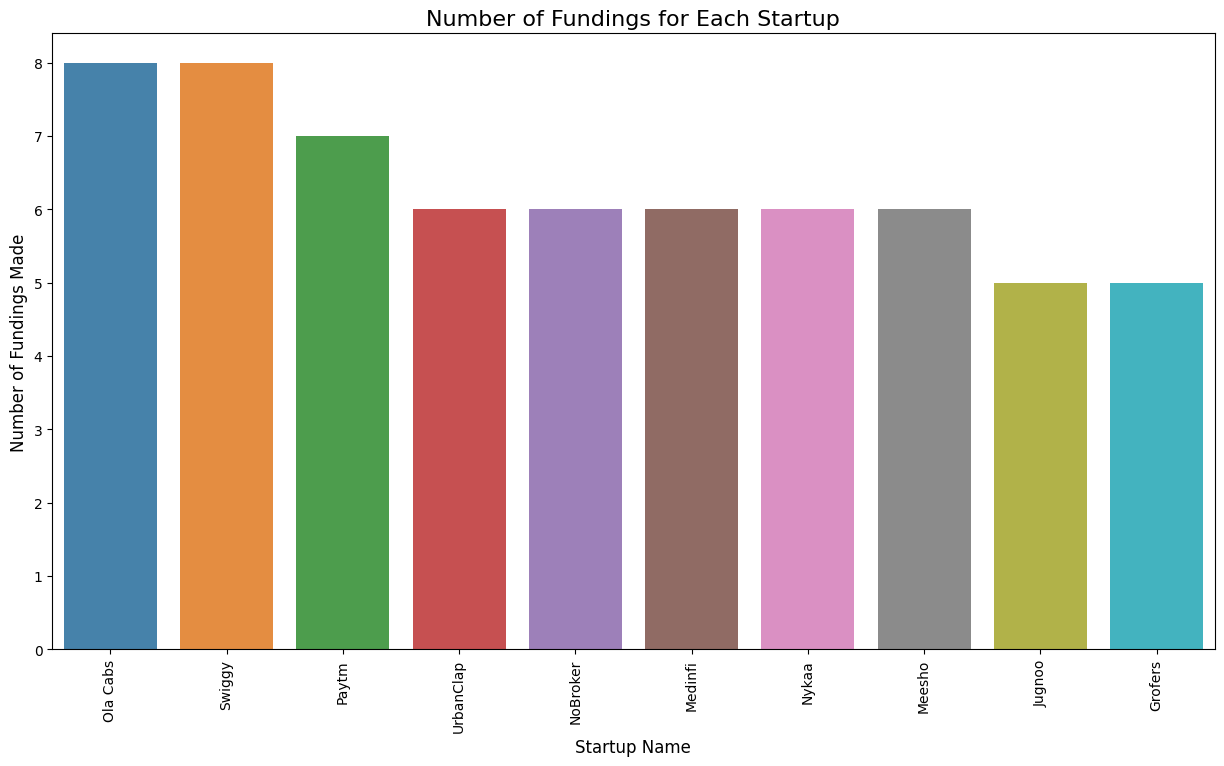

In [221]:
print("Total startups funded : ", len(df["startup_name"].unique()))
# Count the number of fundings for each startup name
startupname = df['startup_name'].value_counts().head(10)

# Plot the bar chart
plt.figure(figsize=(15, 8))
sns.barplot(x=startupname.index, y=startupname.values,alpha=0.9)
plt.xticks(rotation='vertical')
plt.xlabel('Startup Name', fontsize=12)
plt.ylabel('Number of Fundings Made', fontsize=12)
plt.title('Number of Fundings for Each Startup', fontsize=16)
plt.show()

* As we can see that **ola cabs and Swiggy** got maximum number of fundings (Total funding = 8) and total there are **2457** Indian startups funded from 2015 to 2020.

## Industires favored by investor for funding
(Companies who get funding more easily )

> For Vertical

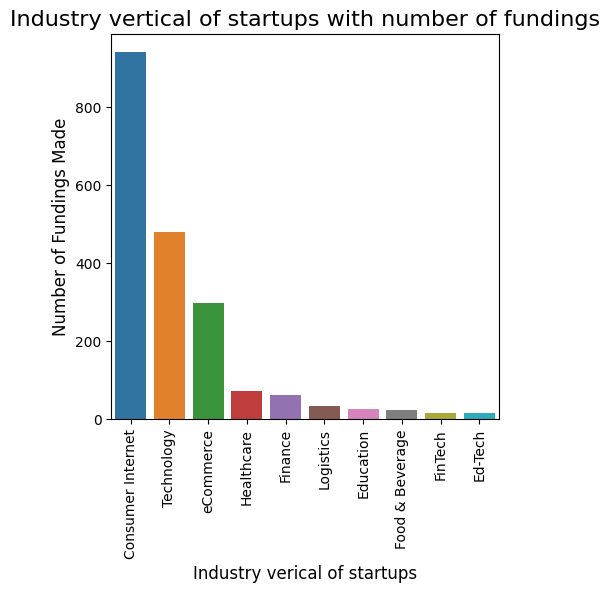

In [245]:
vertical_filtered = df[df['industry_vertical'] != "nan"]
industry_vertical = vertical_filtered['industry_vertical'].value_counts().head(10)

plt.figure(figsize=(5,5))
sns.barplot(x=industry_vertical.index, y= industry_vertical.values)
plt.xticks(rotation='vertical')
plt.xlabel('Industry verical of startups', fontsize=12)
plt.ylabel('Number of Fundings Made', fontsize=12)
plt.title('Industry vertical of startups with number of fundings', fontsize=16)
plt.show()

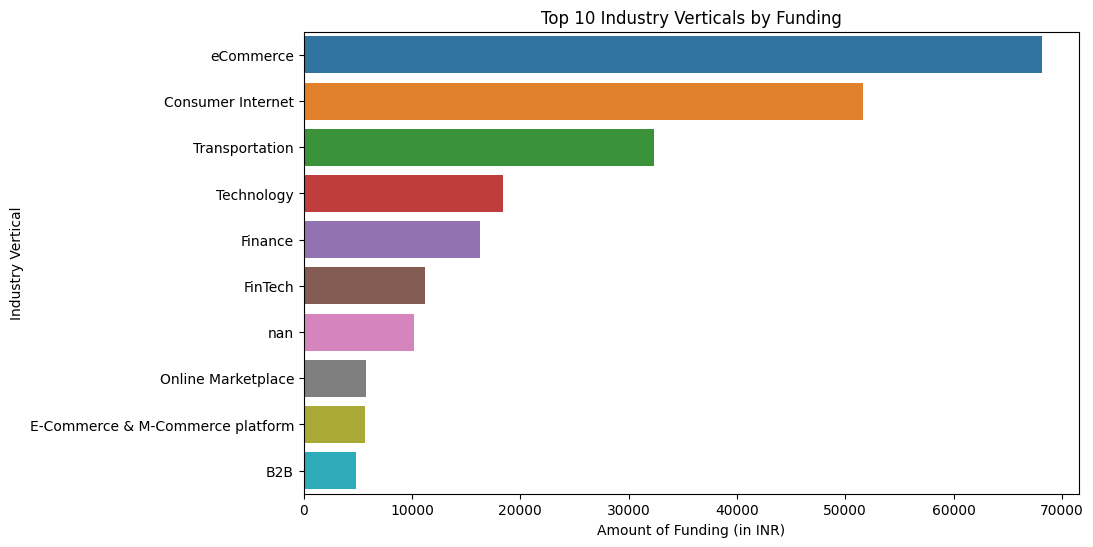

In [246]:
industry_df=df.groupby('industry_vertical',as_index=False)['amount_inr'].sum()
industry_df=industry_df.sort_values(by='amount_inr',ascending=False, ignore_index=1)[0:10]

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='amount_inr', y='industry_vertical', data=industry_df)

ax.set(xlabel='Amount of Funding (in INR)', ylabel='Industry Vertical', title='Top 10 Industry Verticals by Funding')

plt.show()

* As we can see **Consumer Internet** got maximum number of funding (Total No. of funding = 941) followed by technology and eCommerce.

* But **eCommerce** got highest amount folowed by Consumer Internet and Transportation.

> For Sub Vertical

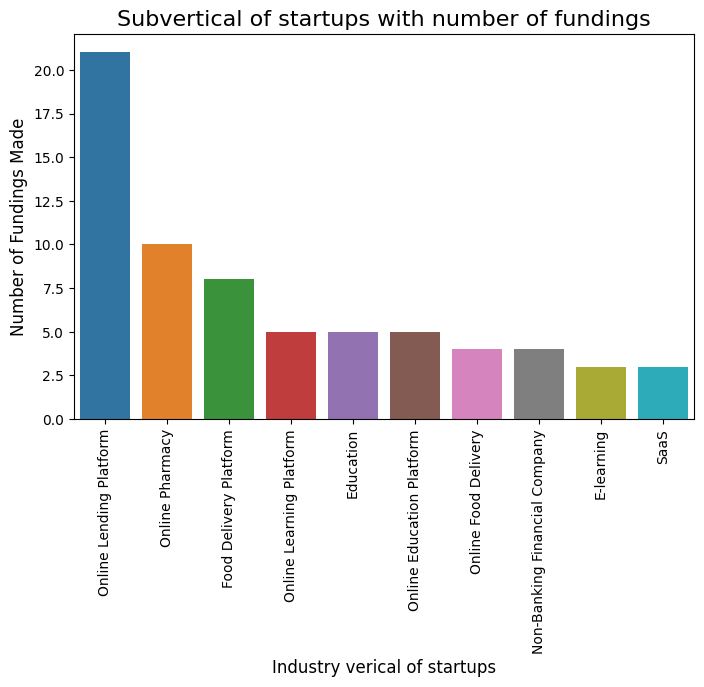

In [247]:
industry_filtered = df[df['sub_vertical'] != 'nan']
industry = industry_filtered['sub_vertical'].value_counts().head(10)

plt.figure(figsize=(8,5))
sns.barplot(x=industry.index, y= industry.values)
plt.xticks(rotation='vertical')
plt.xlabel('Industry verical of startups', fontsize=12)
plt.ylabel('Number of Fundings Made', fontsize=12)
plt.title('Subvertical of startups with number of fundings', fontsize=16)
plt.show()

* In Subcategories **Online Lending Platform** got maximum number of fundings, followed by Online Pharmacy and food delivery Platform

## Do cities play a major role in funding ?

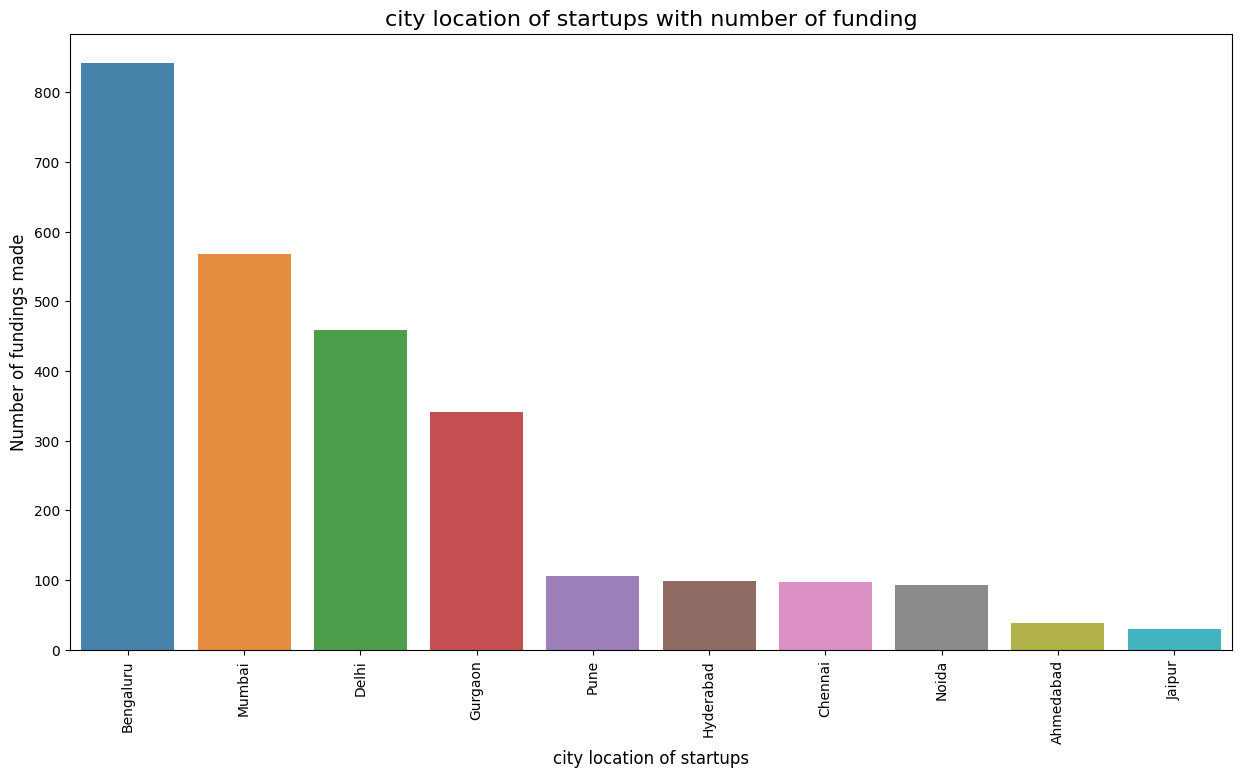

In [248]:
city_filtered = df[df['city_location'] != "nan"]
city = city_filtered['city_location'].value_counts().head(10)

plt.figure(figsize=(15,8))
sns.barplot(x=city.index, y=city.values, alpha=0.9)
plt.xticks(rotation='vertical')
plt.xlabel('city location of startups', fontsize=12)
plt.ylabel('Number of fundings made', fontsize=12)
plt.title("city location of startups with number of funding", fontsize=16)
plt.show()

* So *Bengaluru*, *Mumbai* , *Delhi* and *Gurgaon* are among top cities investors prefered.

## Distribution of startups across Top Different cities

Text(0.5, 1.0, 'Distribution of startups across Top 10 Cities')

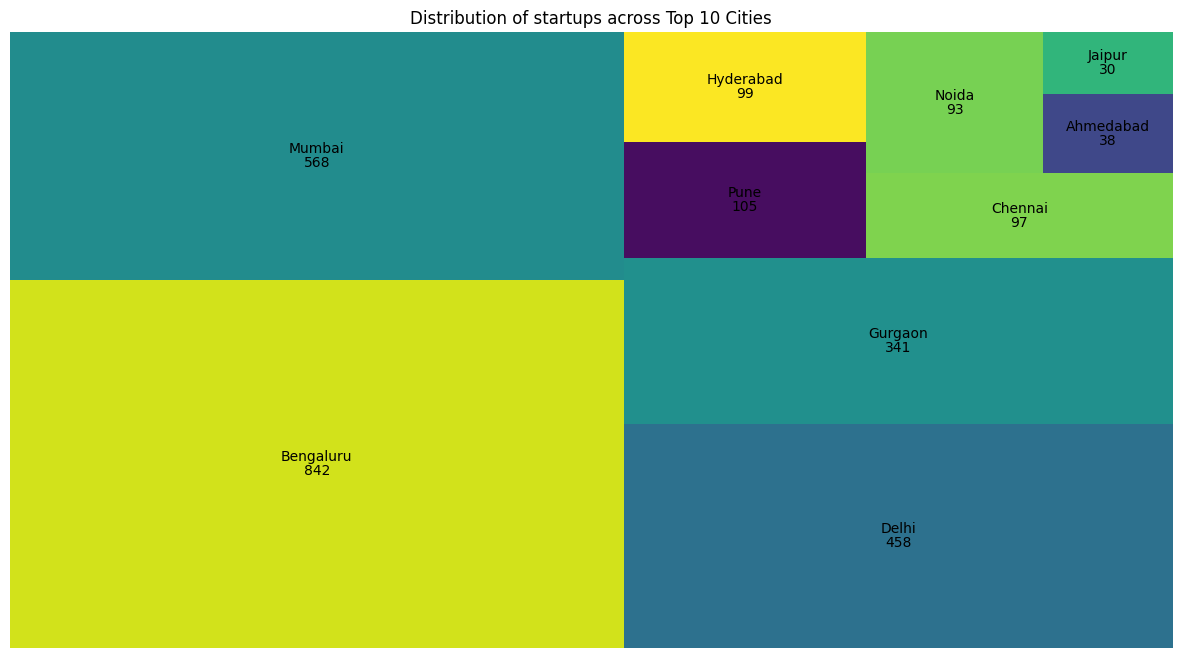

In [249]:
count = city_filtered['city_location'].value_counts().head(10)
plt.figure(figsize=(15,8))
squarify.plot(sizes=count.values,label=count.index,value=count.values)
plt.axis('off')
plt.title("Distribution of startups across Top 10 Cities")

* We can see **Banglore** attracts more number of investors folowed by Mumbai and New Delhi

## Important investors in Indian Ecosystem

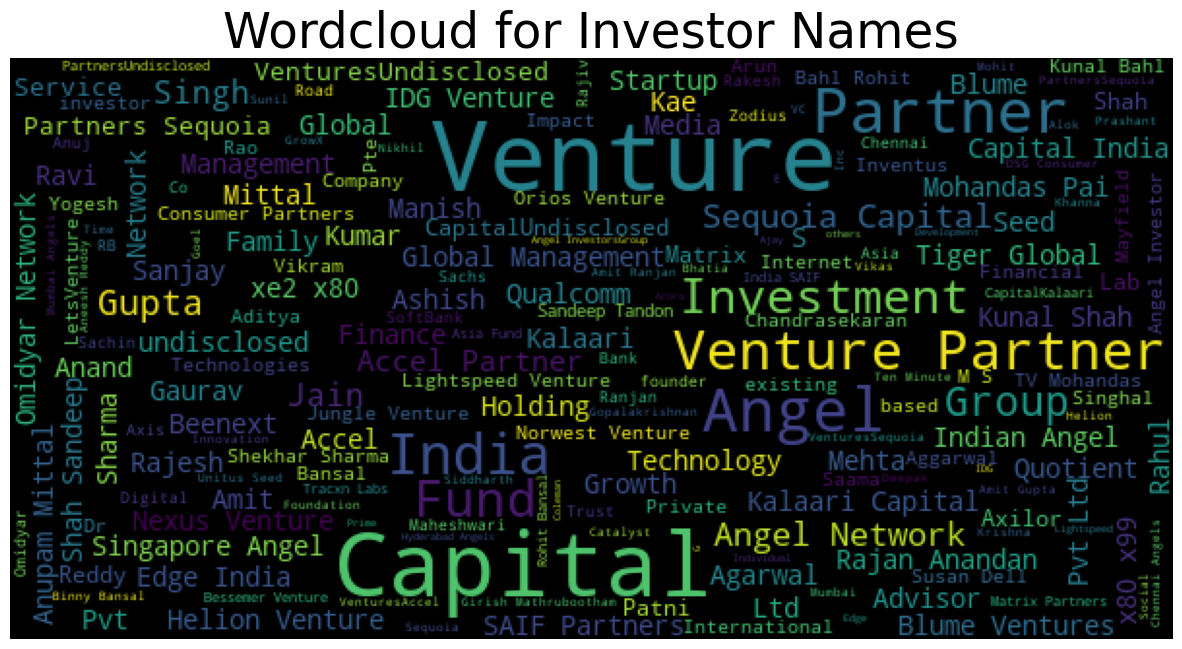

In [227]:
names = df['investor_name'][~pd.isnull(df['investor_name'])]

wordcloud = WordCloud(max_font_size=50,width=600,height=300).generate(''.join(names))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.title("Wordcloud for Investor Names", fontsize=35)
plt.axis("off")
plt.show()


## Top 10 Investors

In [228]:
df['investor_name'] = df['investor_name'].replace(['Undisclosed investors', 'Undisclosed Investor', 'Undisclosed', 'undisclosed investors', 'nan'], 'Undisclosed Investors')

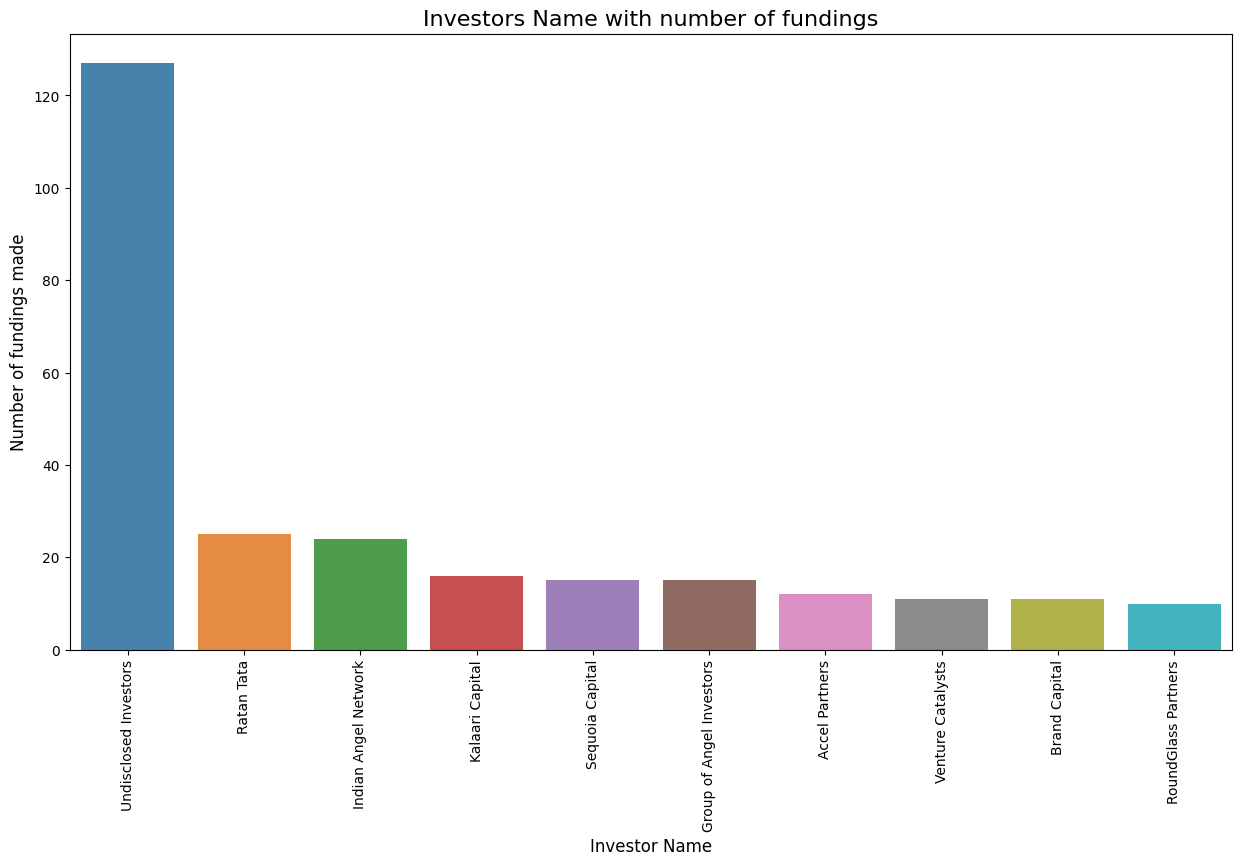

In [243]:
investors = df['investor_name'].value_counts().head(10)
plt.figure(figsize=(15,8))
sns.barplot(x=investors.index, y=investors.values,alpha=0.9)
plt.xticks(rotation='vertical')
plt.xlabel('Investor Name',fontsize=12)
plt.ylabel('Number of fundings made',fontsize=12)
plt.title("Investors Name with number of fundings", fontsize=16)
plt.show()


* **Sir Ratan Tata and Indian Angel Newtork** funded in maximum number of startups 
* there is a huge number of funding done which is undisclosed to public

In [231]:
filterd_investors = df[df['investor_name'] != 'Undisclosed Investors']
investors_10= filterd_investors['investor_name'].value_counts().head(10)
investors_10

Ratan Tata                  25
Indian Angel Network        24
Kalaari Capital             16
Group of Angel Investors    15
Sequoia Capital             15
Accel Partners              12
Brand Capital               11
Venture Catalysts           11
SAIF Partners               10
RoundGlass Partners         10
Name: investor_name, dtype: int64

### Funding Ecosystem over the timeperiod 2015-2020

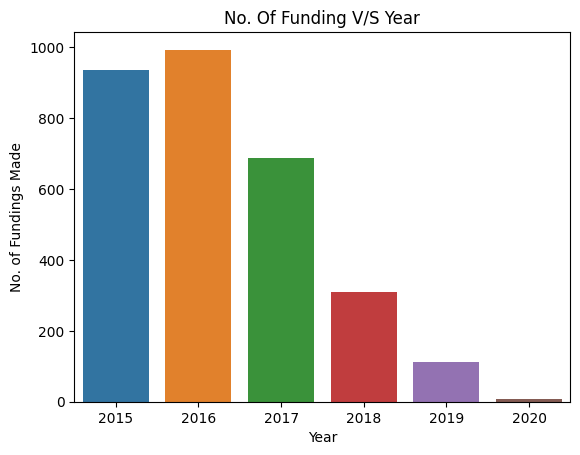

In [241]:
bar_var=df.date.dt.year.value_counts()
ax = sns.barplot(x=bar_var.index,y=bar_var.values)
ax.set(xlabel='Year', ylabel='No. of Fundings Made',title="No. Of Funding V/S Year")
plt.show()

* Number of funding over the year decreases 
* Highest Number of funding was in 2016

In [233]:
df['investment_type'] = df['investment_type'].replace(r'Seed\\nFunding', 'Seed / Angel Funding')

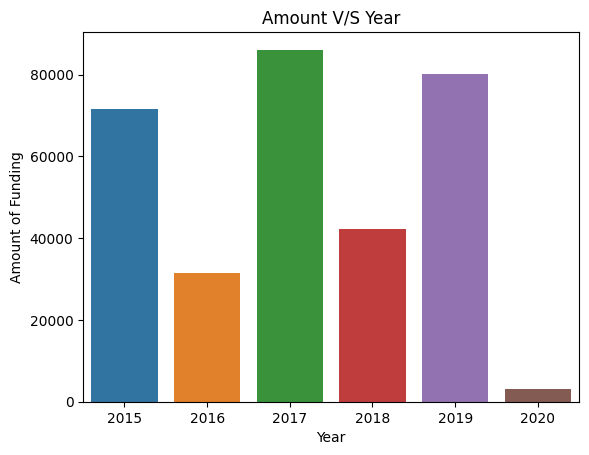

In [240]:
df['year']=df.date.dt.year

df_year=df.groupby('year',as_index=False)['amount_inr'].sum()

ax = sns.barplot(x=df_year.year,y=df_year.amount_inr,data=df_year)
ax.set(xlabel='Year', ylabel='Amount of Funding',title="Amount V/S Year")
plt.show()

* We notice that the decrese in number of funding dosent affect the amount for funding 
* But there is sudden drop in year 2020. maybe due to data is insufficient or due to covid

In [235]:
invest_count=df.investment_type.value_counts()
invest_count.head(3)

Seed / Angel Funding    1541
Private Equity          1363
Debt Funding              25
Name: investment_type, dtype: int64

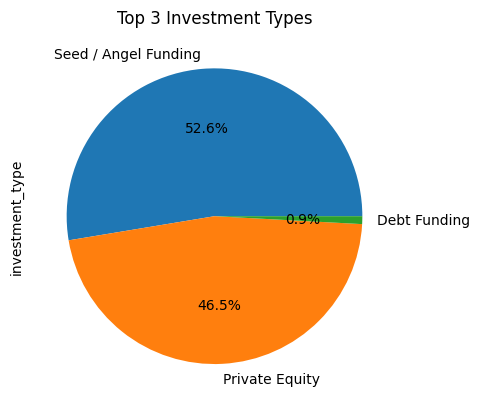

In [236]:
invest_count = df['investment_type'].value_counts().head(3)

invest_count.plot.pie(autopct='%1.1f%%')

plt.title('Top 3 Investment Types')
plt.show()

* The Top 3 Investment Types are - 
1. Seed / Angel Funding = 52.6%  
2. Private Equity       = 46.5%   
3. Debt Funding         = 0.9%    


# CONCLUSION

>Based on the analysis of Indian startup funding data from 2015 to 2020, we can draw several conclusions and provide advice for both new startup owners and investors.

1. It is important to note that there are missing values in several columns, including remarks, amount_usd,     sub_vertical, city_location, and industry_vertical. Therefore, it is crucial to address and handle missing data appropriately before drawing any definitive conclusions.

2. Funding Amounts: 
* The highest funded startup in the dataset is "Rapido Bike Taxi" with funding of 32,186.7 crores. On average, Indian startups received funding of 151 crores. However, it is essential to consider that these numbers are specific to the dataset analyzed, and funding amounts may vary widely in reality.


3. Number of Funded Startups: 
* A total of 2,457 Indian startups were funded from 2015 to 2020. Notably, "Ola Cabs" and "Swiggy" received the maximum number of fundings (8 each), indicating their popularity and investor confidence in these ventures.


4. Funding by Sector: 
* The Consumer Internet sector received the maximum number of fundings (941), followed by Technology and eCommerce. However, in terms of funding amount, eCommerce was the highest, followed by Consumer Internet and Transportation.


5. Subcategories: 
* Within the sectors, specific subcategories received significant funding. Notably, "Online Lending Platform" attracted the highest number of fundings, followed by "Online Pharmacy" and "Food Delivery Platform." New startups in these subcategories may find a favorable investment climate.


6. Preferred Cities: 
* Investors showed a preference for cities like Bengaluru, Mumbai, Delhi, and Gurgaon. These cities have established ecosystems, infrastructure, and access to resources that make them attractive to startups and investors alike.


7. Prominent Investors: 
* Ratan Tata and Indian Angel Network emerged as key investors, contributing to the maximum number of startups. Their involvement indicates a strong endorsement and support for the startups they have funded.


8. Undisclosed Funding: 
* It is worth noting that a significant number of funding rounds remain undisclosed to the public. This suggests that there may be additional funding opportunities beyond the dataset's scope, making it crucial for startups to explore various avenues and investor networks.


9. Funding Trends: 
* The number of funding rounds decreased over the years, with the highest number in 2016 (993) and a significant drop in 2020 (7). While the decrease in the number of fundings may be a concern, the funding amounts remained relatively stable, except for the sharp drop in 2020. This could be attributed to various factors such as insufficient data or the impact of the COVID-19 pandemic.


10. Investment Types: 
* The top three investment types were Seed/Angel Funding (52.6%), Private Equity (46.5%), and Debt Funding (0.9%). Startup owners and investors should be aware of these investment types and explore suitable options based on their specific requirements and risk tolerance.